# Packages

In [22]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import make_interp_spline
import seaborn as sns
from matplotlib.colors import to_rgba

# Global Settings

In [20]:
# Set global style parameters
plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Color scheme
IMU_COLOR = '#1f77b4'  # Blue
MOCAP_COLOR = '#ff7f0e'  # Orange
DIFF_COLOR = '#2ca02c'  # Green
SPLINE_COLOR = '#d62728'  # Red
TRIAL_COLORS = plt.cm.viridis  # Colormap for trials

C:\Users\adker\AppData\Local\Temp\ipykernel_15340\2651852267.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Functions

## Data Cleaning

In [7]:
def parse_filename_components(df_dict):
    """Adds columns for trial number and time range extracted from filenames"""
    for name, df in df_dict.items():
        # Extract components using regular expression
        match = re.match(r'^(\d+)(.*?)_(IMU|MoCap)_(\d+s)_to_(\d+s)$', name)
        
        if match:
            # Add new columns
            df['TrialNumber'] = int(match.group(1))  # First number in filename
            df['TimeRange'] = f"{match.group(4)}-{match.group(5)}"  # Time range
            df['Duration'] = float(match.group(5).replace('s','')) - float(match.group(4).replace('s',''))
        else:
            print(f"Warning: Filename format not recognized for {name}")
            df['TrialNumber'] = None
            df['TimeRange'] = None
            df['Duration'] = None
    
    return df_dict

## Visualizations

In [29]:
def get_trial_data(dict_data, trial_num, device):
    """Helper to get specific trial data"""
    for df in dict_data.values():
        if (df['TrialNumber'].iloc[0] == trial_num and 
            df['Device'].iloc[0].lower() == device.lower()):
            return df
    return None

def smooth_data(x, y, smoothing_factor=0.05):
    """Apply smoothing spline with error handling"""
    if len(x) < 4:
        return x, y
    try:
        spline = make_interp_spline(x, y)
        x_smooth = np.linspace(min(x), max(x), int(len(x) * (1 + smoothing_factor)))
        return x_smooth, spline(x_smooth)
    except:
        return x, y

def plot_all_device_data(dict_data, motion_name, device):
    """Plot all trials for one device type"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    trial_numbers = sorted({df['TrialNumber'].iloc[0] for df in dict_data.values() 
                          if df['Device'].iloc[0].lower() == device.lower()})
    
    for trial in trial_numbers:
        df = get_trial_data(dict_data, trial, device)
        if df is not None:
            time = df.iloc[:, 0]
            values = df.iloc[:, 1]
            ax.plot(time, values, label=f'Trial {trial}', alpha=0.7)
    
    ax.set_title(f'{motion_name} - All {device} Trials')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (degrees)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig

def plot_differences(dict_data, motion_name, smooth=True, 
                    color_by_trial=True, overall_spline=True,
                    diff_color=DIFF_COLOR, spline_color=SPLINE_COLOR,
                    diff_alpha=0.7, spline_alpha=0.9, spline_linewidth=3):
    """
    Difference plot with option for overall smoothing spline
    
    Parameters:
    - overall_spline: If True, fits one spline to all combined differences
    - color_by_trial: Color each trial differently when overall_spline=False
    - spline_color: Color for the smoothing spline
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    trial_numbers = sorted({df['TrialNumber'].iloc[0] for df in dict_data.values()})
    n_trials = len(trial_numbers)
    
    # Store all differences for overall spline
    all_times = []
    all_differences = []
    
    for i, trial in enumerate(trial_numbers):
        imu_df = get_trial_data(dict_data, trial, 'IMU')
        mocap_df = get_trial_data(dict_data, trial, 'MoCap')
        
        if imu_df is not None and mocap_df is not None:
            # Find common time range
            time_min = max(imu_df.iloc[0, 0], mocap_df.iloc[0, 0])
            time_max = min(imu_df.iloc[-1, 0], mocap_df.iloc[-1, 0])
            common_time = np.linspace(time_min, time_max, 1000)
            
            # Interpolate both signals
            imu_interp = np.interp(common_time, imu_df.iloc[:, 0], imu_df.iloc[:, 1])
            mocap_interp = np.interp(common_time, mocap_df.iloc[:, 0], mocap_df.iloc[:, 1])
            difference = mocap_interp - imu_interp
            
            # Store for overall spline
            all_times.append(common_time)
            all_differences.append(difference)
            
            # Plot individual trial differences
            if not overall_spline:
                if color_by_trial:
                    trial_color = TRIAL_COLORS(i/n_trials)
                else:
                    trial_color = diff_color
                
                ax.plot(common_time, difference, 
                       color=trial_color,
                       alpha=diff_alpha,
                       label=f'Trial {trial}' if color_by_trial else None)
    
    # Create overall spline if requested
    if smooth and overall_spline and all_times:
        # Combine all trial data
        combined_time = np.concatenate(all_times)
        combined_diff = np.concatenate(all_differences)
        
        # Sort by time for spline fitting
        sort_idx = np.argsort(combined_time)
        combined_time = combined_time[sort_idx]
        combined_diff = combined_diff[sort_idx]
        
        # Fit spline to all data
        time_smooth, diff_smooth = smooth_data(combined_time, combined_diff)
        ax.plot(time_smooth, diff_smooth, 
               color=spline_color,
               alpha=spline_alpha,
               linewidth=spline_linewidth,
               label='Overall smoothed difference')
        
        # Plot individual trials faintly in background
        for i, (time, diff) in enumerate(zip(all_times, all_differences)):
            ax.plot(time, diff, 
                   color=to_rgba(TRIAL_COLORS(i/n_trials), 
                   alpha=0.15)
            )
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    title = f'{motion_name} - MoCap vs IMU Differences'
    if smooth and overall_spline:
        title += ' (with overall smoothing)'
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Difference (degrees)')
    
    if smooth or color_by_trial:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig

def plot_single_trial_comparison(dict_data, motion_name, trial_num, 
                               imu_color=IMU_COLOR, mocap_color=MOCAP_COLOR,
                               diff_color=DIFF_COLOR, spline_color=SPLINE_COLOR,
                               smooth_diff=True):
    """Enhanced single trial comparison with coloring options"""
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    
    imu_df = get_trial_data(dict_data, trial_num, 'IMU')
    mocap_df = get_trial_data(dict_data, trial_num, 'MoCap')
    
    if imu_df is not None and mocap_df is not None:
        # Main plot
        ax1 = plt.subplot(gs[0])
        ax1.plot(imu_df.iloc[:, 0], imu_df.iloc[:, 1], 
                label='IMU', color=imu_color, alpha=0.8, linewidth=2)
        ax1.plot(mocap_df.iloc[:, 0], mocap_df.iloc[:, 1], 
                label='MoCap', color=mocap_color, alpha=0.8, linewidth=2)
        
        # Common time range
        time_min = max(imu_df.iloc[0, 0], mocap_df.iloc[0, 0])
        time_max = min(imu_df.iloc[-1, 0], mocap_df.iloc[-1, 0])
        common_time = np.linspace(time_min, time_max, 1000)
        
        # Calculate difference
        imu_interp = np.interp(common_time, imu_df.iloc[:, 0], imu_df.iloc[:, 1])
        mocap_interp = np.interp(common_time, mocap_df.iloc[:, 0], mocap_df.iloc[:, 1])
        difference = mocap_interp - imu_interp
        
        # Difference plot
        ax2 = plt.subplot(gs[1])
        
        if smooth_diff:
            # Plot original difference faintly
            ax2.plot(common_time, difference, 
                    color=to_rgba(diff_color, 0.3),
                    linewidth=1)
            
            # Plot smoothed version prominently
            time_smooth, diff_smooth = smooth_data(common_time, difference)
            ax2.plot(time_smooth, diff_smooth, 
                    color=spline_color,
                    alpha=0.9,
                    linewidth=2,
                    label='Smoothed difference')
        else:
            ax2.plot(common_time, difference, 
                    color=diff_color,
                    alpha=0.8,
                    label='Difference')
        
        ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
        
        # Formatting
        ax1.set_title(f'{motion_name} - Trial {trial_num} Comparison')
        ax1.set_ylabel('Angle (degrees)')
        ax1.legend()
        
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Difference')
        if smooth_diff:
            ax2.legend()
        
        plt.tight_layout()
    
    return fig

# Data Read-in

In [5]:
# Get all csv files in the folder
folder_path = 'Aligned Data All Participants'

# Initialize separate dictionaries
axial_rotation = {}
flexion = {}
lateral_bending = {}

# Get all CSV files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

for file in all_files:
    try:
        # Get the filename without path or extension
        filename = os.path.splitext(os.path.basename(file))[0]
        
        # Read the CSV file
        df = pd.read_csv(file)

        # Add source column (IMU or MoCap)
        if 'IMU' in filename.upper():
            df['Device'] = 'IMU'
        elif 'MOCAP' in filename.upper():
            df['Device'] = 'MoCap'
        else:
            df['Device'] = 'Unknown'
            print(f"Warning: Couldn't determine source for {filename}")
        
        # Add filename as a column for reference
        df['Filename'] = filename 
        
        # Categorize based on filename
        if 'AxialRotation' in filename:
            axial_rotation[filename] = df
        elif 'Flexion' in filename:
            flexion[filename] = df
        elif 'LateralBending' in filename:
            lateral_bending[filename] = df
        else:
            print(f"File {filename} didn't match any category")
            
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

print(f"Loaded {len(axial_rotation)} AxialRotation files")
print(f"Loaded {len(flexion)} Flexion files")
print(f"Loaded {len(lateral_bending)} LateralBending files")

Loaded 52 AxialRotation files
Loaded 56 Flexion files
Loaded 54 LateralBending files


In [8]:
axial_rotation = parse_filename_components(axial_rotation)
flexion = parse_filename_components(flexion)
lateral_bending = parse_filename_components(lateral_bending)

# Visualizations

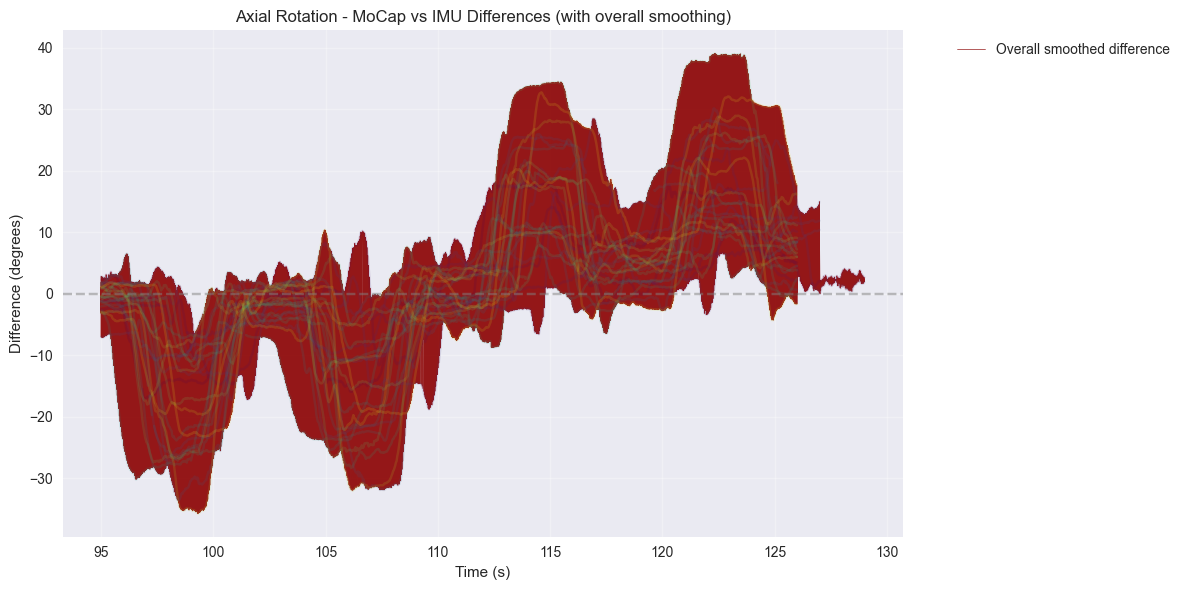

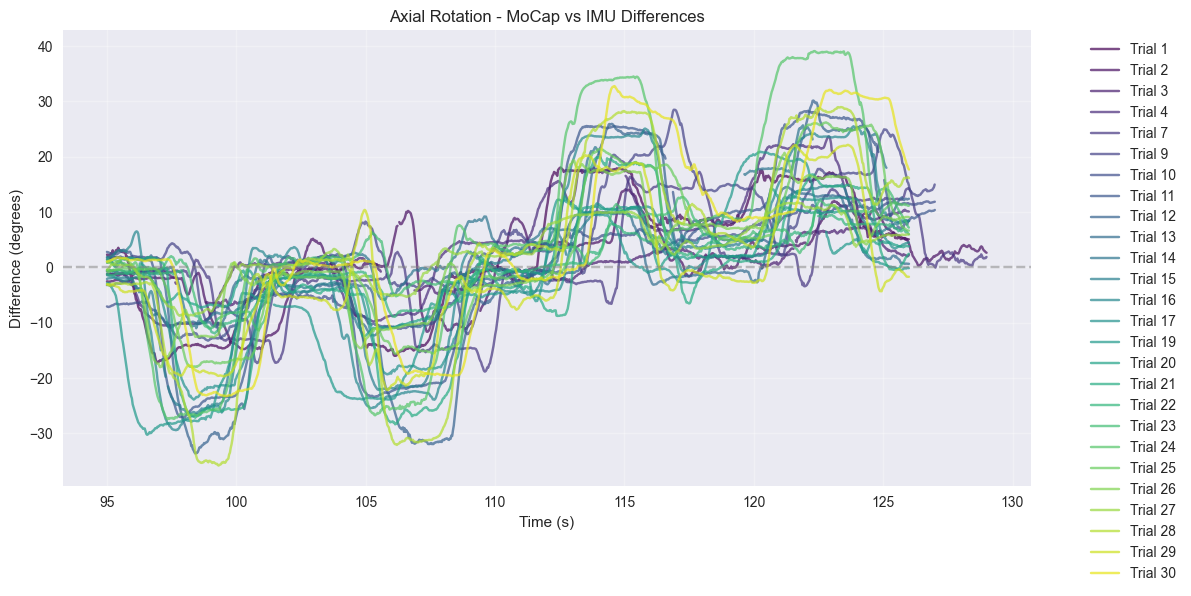

In [33]:
# Generate all requested plots for each motion type
motion_data = {
    'Axial Rotation': axial_rotation
    # 'Flexion': flexion,
    # 'Lateral Bending': lateral_bending
}

# for motion_name, data in motion_data.items():
#     # Plot all IMU trials
#     # plot_all_device_data(data, motion_name, 'IMU')
    
#     # Plot all MoCap trials
#     # plot_all_device_data(data, motion_name, 'MoCap')
    
#     # Plot differences
#     plot_differences(data, motion_name, smooth=True)
#     plot_differences(data, motion_name, smooth=False)
    
#     # Plot individual trial comparisons (example for trial 1)
#     # plot_single_trial_comparison(data, motion_name, 1)

# plt.show()

# Example usage:
for motion_name, data in motion_data.items():
    # Plot with overall smoothing spline
    plot_differences(data, motion_name, 
                    smooth=True,
                    overall_spline=True,  # This is the key parameter
                    spline_color='darkred',
                    spline_linewidth=.5)
    
    # For comparison: plot with individual splines
    plot_differences(data, motion_name,
                    smooth=True,
                    overall_spline=False,
                    color_by_trial=True)

plt.show()